In [1]:
import sys
print(sys.executable)

C:\Users\sivan\PycharmProjects\TPNILM\venv\Scripts\python.exe


In [2]:
# a small README:
# this is runnable from scratch, when having the files:
# house_x_labels.dat (x in 1 to 5), the notebook and a kernel of the requirements file.
# in cell 3 it is needed to uncomment the download lines, in case UKDATE ds wasn't downloaded yet, as well as uncommenting the unpacking of it, 
# and uncommenting the zip removal if desired.

In [46]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import math
from collections import defaultdict, OrderedDict
import copy

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build dataset

In [4]:
import requests
from tqdm import tqdm

def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()  # Raise an error for bad responses
        total_size = int(r.headers.get('content-length', 0))
        with open(local_filename, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    bar.update(len(chunk))

# Call the download function
# url = "https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2015/UK-DALE-disaggregated/ukdale.h5.tgz"
# download_file(url, "ukdale.h5.tgz")


In [5]:
# !tar xvfz ukdale.h5.tgz

In [6]:
# !rm ukdale.h5.tgz

In [7]:
store = pd.HDFStore('ukdale.h5')

In [8]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')


In [9]:
def get_series(datastore, house, label, cutoff):
    filename = './house_%1d_labels.dat' %house
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '1min', cutoff)
            #s = resample_meter(store, house, i, '6s', cutoff)
    
    s.index.name = 'to_datetime'
    
    return s

In [10]:
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_1 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_1.ffill(inplace=True)

ds_1_train = ds_1[pd.to_datetime('2013-04-12 00:00:00+00:00'):pd.to_datetime('2014-12-15 00:00:00+00:00')]
ds_1_valid = ds_1[pd.to_datetime('2014-12-15 00:00:00+00:00'):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
10 kettle
./house_1_labels.dat
12 fridge
./house_1_labels.dat
5 washing_machine
./house_1_labels.dat
13 microwave
./house_1_labels.dat
6 dishwasher


In [11]:
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'
ds_2 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_2.ffill(inplace=True)

ds_2_train = ds_2[pd.to_datetime('2013-05-22 00:00:00+00:00'):pd.to_datetime('2013-10-03 06:16:00+00:00')]
ds_2_valid = ds_2[pd.to_datetime('2013-10-03 06:16:00+00:00'):]

./house_2_labels.dat
1 aggregate
./house_2_labels.dat
8 kettle
./house_2_labels.dat
14 fridge
./house_2_labels.dat
12 washing_machine
./house_2_labels.dat
15 microwave
./house_2_labels.dat
13 dish_washer


In [12]:
house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_3 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_3.ffill(inplace=True)

ds_3_train = ds_3[pd.to_datetime('2013-02-27 00:00:00+00:00'):pd.to_datetime('2013-04-01 06:15:00+00:00')]
ds_3_valid = ds_3[pd.to_datetime('2013-04-01 06:15:00+00:00'):]

./house_3_labels.dat
1 aggregate
./house_3_labels.dat
2 kettle


In [13]:
house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle_radio', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_4 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_4.ffill(inplace=True)

ds_4_train = ds_4[pd.to_datetime('2013-03-09 00:00:00+00:00'):pd.to_datetime('2013-09-24 06:15:00+00:00')]
ds_4_valid = ds_4[pd.to_datetime('2013-09-24 06:15:00+00:00'):]

./house_4_labels.dat
1 aggregate
./house_4_labels.dat
3 kettle_radio
./house_4_labels.dat
5 freezer


In [14]:
house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_5 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_5.ffill(inplace=True)

ds_5_train = ds_5[pd.to_datetime('2014-06-29 00:00:00+00:00'):pd.to_datetime('2014-09-01 00:00:00+00:00')]
ds_5_valid = ds_5[pd.to_datetime('2014-09-01 00:00:00+00:00'):]

./house_5_labels.dat
1 aggregate
./house_5_labels.dat
18 kettle
./house_5_labels.dat
19 fridge_freezer
./house_5_labels.dat
24 washer_dryer
./house_5_labels.dat
23 microwave
./house_5_labels.dat
22 dishwasher


In [15]:
ds_5_train

,aggregate,kettle,fridge,washing_machine,microwave,dish_washer
to_datetime,,,,,,
2014-06-29 16:23:00+00:00,769.000000,0.0,106.800003,225.000000,0.000000,0.0
2014-06-29 16:24:00+00:00,1026.633301,0.0,106.300003,389.633331,0.000000,0.0
2014-06-29 16:25:00+00:00,2263.383301,0.0,106.000000,1312.466675,0.000000,0.0
2014-06-29 16:26:00+00:00,957.500000,0.0,106.500000,235.699997,0.000000,0.0
2014-06-29 16:27:00+00:00,1905.300049,0.0,105.300003,1058.266724,0.000000,0.0
...,...,...,...,...,...,...
2014-08-31 23:56:00+00:00,490.000000,0.0,0.000000,15.000000,50.700001,0.0
2014-08-31 23:57:00+00:00,487.133331,0.0,0.000000,14.800000,50.400002,0.0
2014-08-31 23:58:00+00:00,487.399994,0.0,0.000000,14.800000,50.299999,0.0


In [16]:
ds_1_train.reset_index().to_feather('./UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('./UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('./UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('./UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('./UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('./UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('./UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('./UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('./UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('./UKDALE_5_valid.feather')

# Read the feather dataframe resampled


In [77]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition.iloc[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition.iloc[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s.iloc[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s.iloc[on:off] = 1.
    
    return s

In [18]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length
        
    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')
        x -= x.mean()
        
        return x, y, s

    def __len__(self):
        return self.epochs

In [19]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        #return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))

class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        #self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        #return self.upsample(x)
        #return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))

class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))

class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1**k, features * 2**k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2**k, features * 4**k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4**k, features * 8**k, kernel_size=3, padding=0)
        
        self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
        self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
        self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
        self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)

        self.decoder = Decoder(2*features * 8**k, features * 1**k, kernel_size=p**3, stride=p**3)

        self.activation = nn.Conv1d(features * 1**k, out_channels, kernel_size=1, padding=0)

        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        tp1 = self.tpool1(enc4)
        tp2 = self.tpool2(enc4)
        tp3 = self.tpool3(enc4)
        tp4 = self.tpool4(enc4)

        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4], dim=1))

        act = self.activation(dec)
        return act

x = torch.randn(32,1,60*8+2*16)
model = PTPNet(1,3,32)
print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

torch.Size([32, 3, 480])
327619


In [51]:
def train_model(model, batch_size, n_epochs, filename):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the test loss as the model trains
    test_losses = []
    # to track the unseen test loss as the model trains
    unseen_test_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the average test loss per epoch as the model trains
    avg_test_losses = [] 
    # to track the average unseen test loss per epoch as the model trains
    avg_unseen_test_losses = []
    
    min_loss = np.inf
    
    # initialize the early_stopping object
    #patience = 10
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).to(device)
            target_power = target_power.to(device)
            target_status = target_status.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).to(device)
            target_power = target_power.to(device)
            target_status = target_status.to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            valid_losses.append(loss.item())

        ##################    
        # test the model #
        ##################
        
        # seen data
        model.eval() # prep model for evaluation
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).to(device)
            target_power = target_power.to(device)
            target_status = target_status.to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            test_losses.append(loss.item())

        # unseen data
        for data, target_power, target_status in unseen_test_loader:
            data = data.unsqueeze(1).to(device)
            target_power = target_power.to(device)
            target_status = target_status.to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            unseen_test_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        unseen_test_loss = np.average(unseen_test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        avg_unseen_test_losses.append(unseen_test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ' +
                    f'unseen_test_loss: {unseen_test_loss:.5f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        unseen_test_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'Validation loss decreased ({min_loss:.6f} --> {valid_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(filename, weights_only=True))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses, avg_unseen_test_losses

In [21]:
def evaluate_activation(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    s_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).to(device)
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            sh = torch.sigmoid(sh[:,a,:])
            
            s_hat.append(sh.contiguous().view(-1).detach().cpu().numpy())
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    s_hat = np.hstack(s_hat)

    return x_true, p_true, s_true, s_hat

In [22]:
APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

MAX_POWER = 2000.

In [23]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('./UKDALE_%d_train.feather' %(i+1))
    ds.set_index('to_datetime', inplace=True)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

C:\Users\sivan\AppData\Local\Temp\ipykernel_26068\873049420.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[0]:
C:\Users\sivan\AppData\Local\Temp\ipykernel_26068\873049420.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[-1]:
C:\Users\sivan\AppData\Local\Temp\ipykernel_26068\873049420.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[0]:
C:\Users\sivan\AppData\Local\Temp\ipykernel_2

In [24]:
(ds_status[1].diff()==1).sum()

fridge             3525
dish_washer          98
washing_machine      54
dtype: int64

In [25]:
ds_status[1].describe()

,fridge,dish_washer,washing_machine
count,193337.000000,193337.000000,193337.000000
mean,0.377920,0.028918,0.011317
std,0.484869,0.167578,0.105778
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [31]:
ds_status[1]

,fridge,dish_washer,washing_machine
2013-05-22 00:00:00+00:00,1.0,0.0,0.0
2013-05-22 00:01:00+00:00,1.0,0.0,0.0
2013-05-22 00:02:00+00:00,1.0,0.0,0.0
2013-05-22 00:03:00+00:00,1.0,0.0,0.0
2013-05-22 00:04:00+00:00,1.0,0.0,0.0
...,...,...,...
2013-10-03 06:12:00+00:00,0.0,0.0,0.0
2013-10-03 06:13:00+00:00,0.0,0.0,0.0
2013-10-03 06:14:00+00:00,0.0,0.0,0.0
2013-10-03 06:15:00+00:00,0.0,0.0,0.0


In [33]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                #ds_house_train[2], 
                                                #ds_house_train[3],
                                                #ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

ds_test_seen = torch.utils.data.ConcatDataset([ds_house_test[0], 
                                                ds_house_test[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_test_seen, batch_size = BATCH_SIZE, shuffle=False)

# ds_train_unseen = torch.utils.data.ConcatDataset([#ds_house_train[0], 
#                                                   #ds_house_train[1], 
#                                                   #ds_house_train[2], 
#                                                   #ds_house_train[3], 
#                                                   #ds_house_train[4]
#                                                   ])
# ds_valid_unseen = torch.utils.data.ConcatDataset([#ds_house_valid[0], 
#                                                   #ds_house_valid[1], 
#                                                   #ds_house_valid[2], 
#                                                   #ds_house_valid[3], 
#                                                   #ds_house_valid[4]
#                                                   ])
# dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
# dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[4], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

In [34]:
dataiter = iter(dl_house_test[1])

In [35]:
dl_house_test[1]

(-0.5, 1.5)

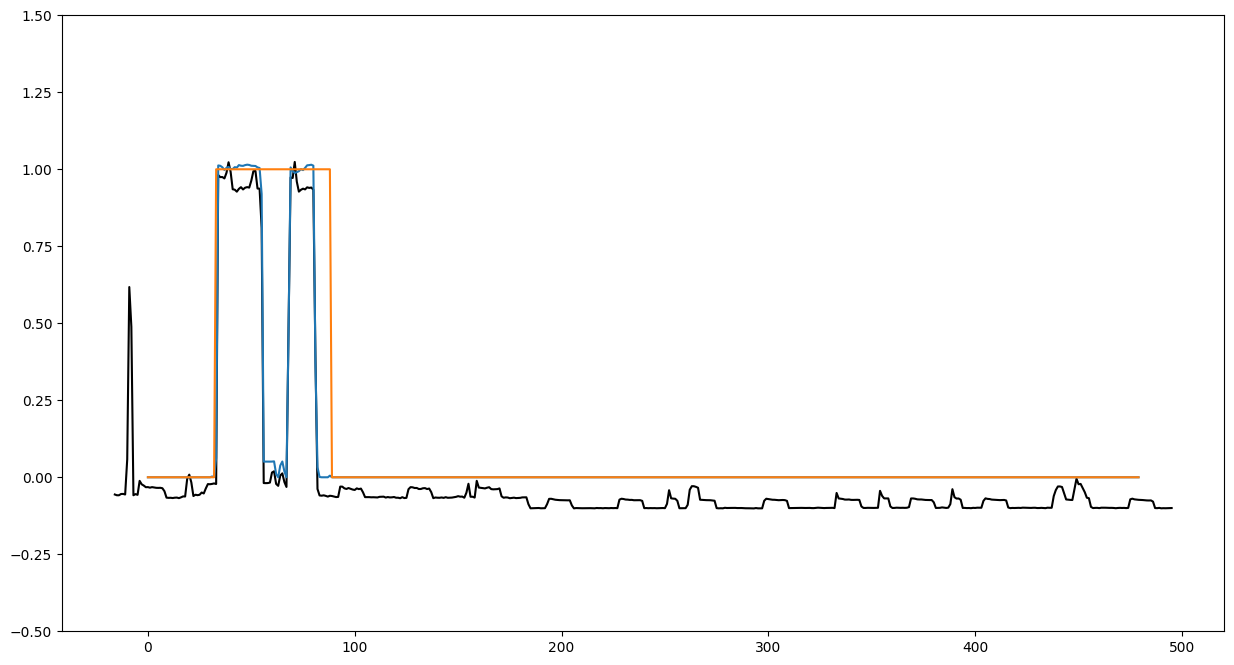

In [36]:
plt.figure(figsize=(15, 8))
#x, y, s = next(dataiter)
a = 1
for i in range(100):
    x, y, s = next(dataiter)  # Use next(dataiter) instead of dataiter.next()
    if y[0, :, a].sum() > 0:
        break
    if s[0, :, a].sum() > 0:
        break

 x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.st


plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x[0, :].detach().numpy(), 'k-', label='meter') 
plt.plot(y[0, :, a].detach().numpy(), label='appliance')
plt.plot(s[0, :, a].detach().numpy(), label='stastus')
plt.ylim([-0.5, 1.5])
plt.legend()

In [54]:
# training code adaptation: short and simple, just to see that it lives 
# (later on we will run the original code to recreate the results):

batch_size = BATCH_SIZE
n_epochs = 50 # a modification here

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen
#unseen test loader
unseen_test_loader = dl_test_unseen


res_dict = {}

#i = 0
for i in range(5): # another modification here
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model = PTPNet(1,3,32).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_seen_%d.pth' %i
    model, train_loss, valid_loss, test_loss, unseen_test_loss = train_model(model, batch_size, n_epochs, fn)
    
    res_dict['UKDALE_model_' + str(i)+'_results'] = {'model_name': fn, 
                                                    'train_loss': train_loss, 
                                                    'valid_loss': valid_loss, 
                                                    'test_loss': test_loss,
                                                    'unseen_test_loss': unseen_test_loss}

    # save res_dict to a file
    with open('res_dict.pkl', 'wb') as f:
        pickle.dump(res_dict, f)
        print('saved results for model ' + fn)

TRAINING MODEL 0
[ 1/50] train_loss: 0.54833 valid_loss: 0.43050 test_loss: 0.43412 unseen_test_loss: 0.41641 
Validation loss decreased (inf --> 0.430502).  Saving model ...
[ 2/50] train_loss: 0.36809 valid_loss: 0.31778 test_loss: 0.32798 unseen_test_loss: 0.31708 
Validation loss decreased (0.430502 --> 0.317780).  Saving model ...
[ 3/50] train_loss: 0.28747 valid_loss: 0.26076 test_loss: 0.27581 unseen_test_loss: 0.27469 
Validation loss decreased (0.317780 --> 0.260760).  Saving model ...
[ 4/50] train_loss: 0.24175 valid_loss: 0.22219 test_loss: 0.23893 unseen_test_loss: 0.25065 
Validation loss decreased (0.260760 --> 0.222195).  Saving model ...
[ 5/50] train_loss: 0.20887 valid_loss: 0.19834 test_loss: 0.21442 unseen_test_loss: 0.23383 
Validation loss decreased (0.222195 --> 0.198338).  Saving model ...
[ 6/50] train_loss: 0.19055 valid_loss: 0.18034 test_loss: 0.19629 unseen_test_loss: 0.22155 
Validation loss decreased (0.198338 --> 0.180338).  Saving model ...
[ 7/50] tr

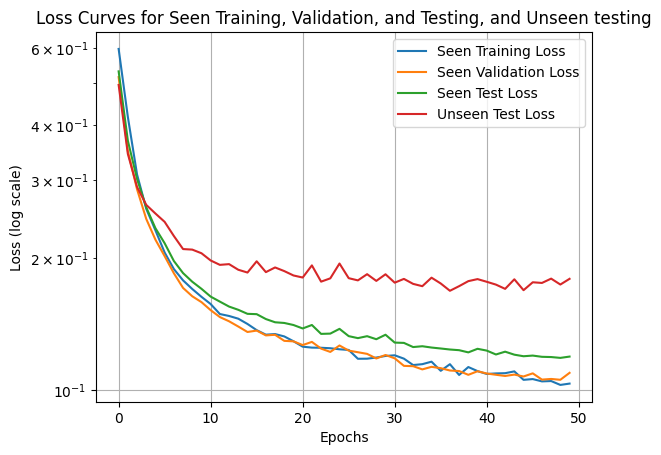

In [65]:
# Plot the loss values
plt.plot(train_loss, label='Seen Training Loss')
plt.plot(valid_loss, label='Seen Validation Loss')
plt.plot(test_loss, label='Seen Test Loss')

plt.plot(unseen_test_loss, label='Unseen Test Loss')


# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Epochs')  # Replace with 'Iterations' if appropriate
plt.ylabel('Loss (log scale)')
plt.title('Loss Curves for Seen Training, Validation, and Testing, and Unseen testing')

# Add a legend to distinguish the lines
plt.legend()

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [78]:
# manipulating the data before arranging it in dls

ds_meter = []
ds_appliance = []
ds_status = []

for i in range(5):
    ds = pd.read_feather('./UKDALE_%d_train.feather' %(i+1))
    ds.set_index('to_datetime', inplace=True)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

In [ ]:
def manipulate_status()

In [101]:
ds_status[0].columns

Index(['fridge', 'dish_washer', 'washing_machine'], dtype='object')

In [103]:
df = ds_status[0]['washing_machine'].reset_index(drop=True)
flip_probability = 0.01
random_values = np.random.rand(len(df))

0.05617164105432887

In [69]:
# manipulated datasets and dataloaders (the manipulation is on the train and validation):

ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                ds_house_valid[1]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)

In [188]:
# manipulated model

class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        #return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))

class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        #self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        #return self.upsample(x)
        #return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))

class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))

# class PTPNet(nn.Module):

#     def __init__(self, in_channels=3, out_channels=1, init_features=32):
#         super(PTPNet, self).__init__()
#         p = 2
#         k = 1
#         features = init_features

#         self.encoder1 = Encoder(in_channels, features, kernel_size=1, padding=0)   
#         self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
#         self.encoder2 = Encoder(features * 1**k, features * 2**k, kernel_size=1, padding=0)
#         self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
#         self.encoder3 = Encoder(features * 2**k, features * 4**k, kernel_size=3, padding=1)
#         self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
#         self.encoder4 = Encoder(features * 4**k, features * 8**k, kernel_size=7, padding=1)
        
#         self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
#         self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
#         self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
#         self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)

#         self.decoder = Decoder(2*features * 8**k, features * 1**k, kernel_size=p**3, stride=p**3)

#         self.activation = nn.Conv1d(features * 1**k, out_channels, kernel_size=1, padding=0)

        
#     def forward(self, x):
#         enc1 = self.encoder1(x)
#         enc2 = self.encoder2(self.pool1(enc1))
#         enc3 = self.encoder3(self.pool2(enc2))
#         enc4 = self.encoder4(self.pool3(enc3))

#         tp1 = self.tpool1(enc4)
#         tp2 = self.tpool2(enc4)
#         tp3 = self.tpool3(enc4)
#         tp4 = self.tpool4(enc4)

#         dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4], dim=1))

#         act = self.activation(dec)
#         return act

# x = torch.randn(32,1,60*8+2*16)
# model = PTPNet(1,3,32)
# print(model(x).shape)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad))

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, init_features=32):
        super(UNet1D, self).__init__()
        features = init_features

        # Encoding path
        self.encoder1 = ConvBlock(in_channels, features)
        self.pool1 = nn.MaxPool1d(kernel_size=100, stride=10)
        self.encoder2 = ConvBlock(features, features * 2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder3 = ConvBlock(features * 2, features * 4)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder4 = ConvBlock(features * 4, features * 8)
        
        # Bottleneck layer
        self.bottleneck = ConvBlock(features * 8, features * 8)
        
        # Decoding path
        self.up3 = nn.ConvTranspose1d(features * 8, features * 8, kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(features * 8 * 2, features * 8)
        self.up2 = nn.ConvTranspose1d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(features * 4 * 2, features * 4)
        self.up1 = nn.ConvTranspose1d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(features * 2 * 2, features * 2)
        
        # Final activation
        self.final_conv = nn.Conv1d(features * 2, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc4))

        # Decoding path
        dec3 = self.up3(bottleneck)
        dec3 = torch.cat((dec3, enc4), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc2), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Final activation to output
        out = self.final_conv(dec1)
        
        return torch.sigmoid(out)




class DilatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(DilatedResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual  # Add the residual connection
        return F.relu(x)

class DilatedCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, init_features=32):
        super(DilatedCNN, self).__init__()
        features = init_features
        
        self.initial_conv = nn.Conv1d(in_channels, features, kernel_size=3, padding=1)

        self.resblock1 = DilatedResidualBlock(features, features, dilation=1)
        self.resblock2 = DilatedResidualBlock(features, features, dilation=2)
        self.resblock3 = DilatedResidualBlock(features, features, dilation=4)

        self.final_conv = nn.Conv1d(features, out_channels, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        
        x = self.final_conv(x)
        return torch.sigmoid(x)

# Example usage
x = torch.randn(32, 1, 256)  # Example input tensor with batch size 32 and 256 timesteps
model = DilatedCNN(in_channels=1, out_channels=3, init_features=32)




# # Example usage
# x = torch.randn(32, 1, 256)  # Example input tensor with batch size 32
# model = UNet1D(in_channels=1, out_channels=3, init_features=32)

# x = torch.randn(32,1,60*8+2*16)
# model = PTPNet(1,3,32)

print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

torch.Size([32, 3, 256])
19235


In [189]:
# manipulated data model training

batch_size = BATCH_SIZE
n_epochs = 50 # a modification here

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen
#unseen test loader
unseen_test_loader = dl_test_unseen


mm_res_dict = {}

#i = 0
for i in range(1): # another modification here
    print('TRAINING MANIPULATED MODEL %d' %i)
    # Instantiate the model
    model = PTPNet(1,3,32).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_seen_%d_manipulated_model.pth' %i
    mm_model, mm_train_loss, mm_valid_loss, mm_test_loss, mm_unseen_test_loss = train_model(model, batch_size, n_epochs, fn)
    
    mm_res_dict['UKDALE_manipulated_model_' + str(i)+'_results'] = {'model_name': fn, 
                                                    'train_loss': mm_train_loss, 
                                                    'valid_loss': mm_valid_loss, 
                                                    'test_loss': mm_test_loss,
                                                    'unseen_test_loss': mm_unseen_test_loss}

    # save res_dict to a file
    with open('manipulated_model_res_dict.pkl', 'wb') as f:
        pickle.dump(mm_res_dict, f)
        print('saved results for model ' + fn)

TRAINING MANIPULATED MODEL 0
[ 1/50] train_loss: 0.60377 valid_loss: 0.48449 test_loss: 0.47971 unseen_test_loss: 0.49188 
Validation loss decreased (inf --> 0.484491).  Saving model ...
[ 2/50] train_loss: 0.40506 valid_loss: 0.34355 test_loss: 0.35350 unseen_test_loss: 0.34109 
Validation loss decreased (0.484491 --> 0.343553).  Saving model ...
[ 3/50] train_loss: 0.30470 valid_loss: 0.28107 test_loss: 0.29450 unseen_test_loss: 0.28962 
Validation loss decreased (0.343553 --> 0.281067).  Saving model ...
[ 4/50] train_loss: 0.25548 valid_loss: 0.24228 test_loss: 0.25676 unseen_test_loss: 0.26595 
Validation loss decreased (0.281067 --> 0.242281).  Saving model ...
[ 5/50] train_loss: 0.22246 valid_loss: 0.21349 test_loss: 0.22926 unseen_test_loss: 0.25094 
Validation loss decreased (0.242281 --> 0.213494).  Saving model ...
[ 6/50] train_loss: 0.20175 valid_loss: 0.19776 test_loss: 0.21331 unseen_test_loss: 0.24536 
Validation loss decreased (0.213494 --> 0.197758).  Saving model ..

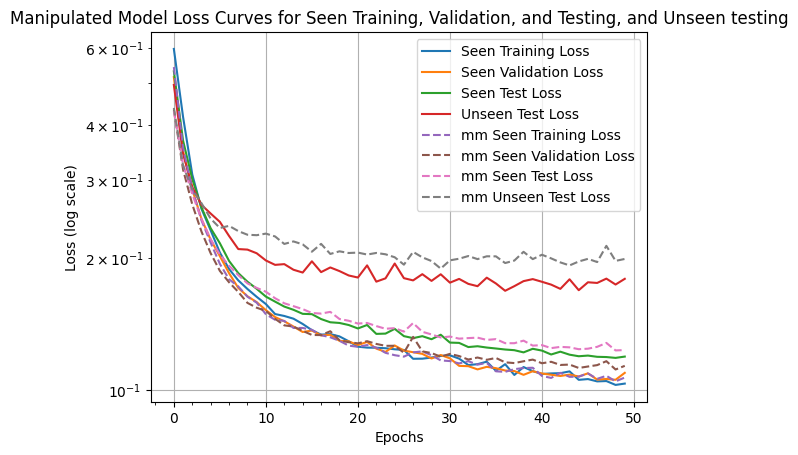

In [187]:
# Manipulated Model plots

# plot the original model results
plt.plot(train_loss, label='Seen Training Loss')
plt.plot(valid_loss, label='Seen Validation Loss')
plt.plot(test_loss, label='Seen Test Loss')

plt.plot(unseen_test_loss, label='Unseen Test Loss')

# Plot the manipulated model results
plt.plot(mm_train_loss, label='mm Seen Training Loss', linestyle='--')
plt.plot(mm_valid_loss, label='mm Seen Validation Loss', linestyle='--')
plt.plot(mm_test_loss, label='mm Seen Test Loss', linestyle='--')

plt.plot(mm_unseen_test_loss, label='mm Unseen Test Loss', linestyle='--')


# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Epochs')  # Replace with 'Iterations' if appropriate
plt.ylabel('Loss (log scale)')
plt.title('Manipulated Model Loss Curves for Seen Training, Validation, and Testing, and Unseen testing')

# Add a legend to distinguish the lines
plt.legend()

# Display grid for better readability
plt.minorticks_on()
plt.grid(True)

# Show the plot
plt.show()

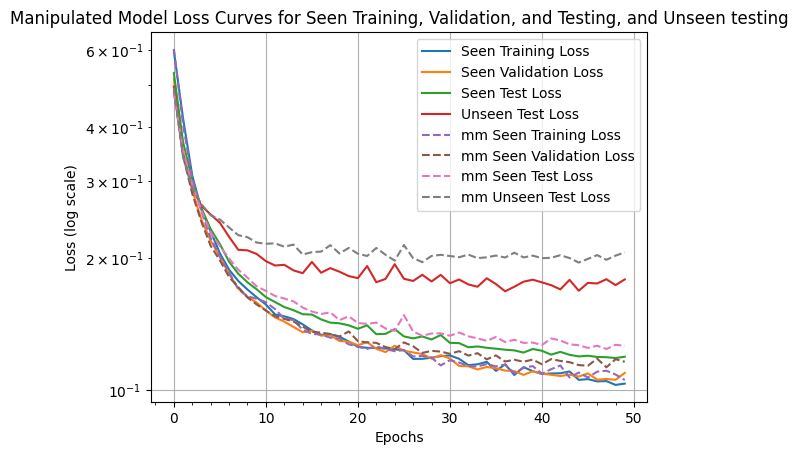

In [190]:
# Manipulated Model plots - no encoders results

# plot the original model results
plt.plot(train_loss, label='Seen Training Loss')
plt.plot(valid_loss, label='Seen Validation Loss')
plt.plot(test_loss, label='Seen Test Loss')

plt.plot(unseen_test_loss, label='Unseen Test Loss')

# Plot the manipulated model results
plt.plot(mm_train_loss, label='mm Seen Training Loss', linestyle='--')
plt.plot(mm_valid_loss, label='mm Seen Validation Loss', linestyle='--')
plt.plot(mm_test_loss, label='mm Seen Test Loss', linestyle='--')

plt.plot(mm_unseen_test_loss, label='mm Unseen Test Loss', linestyle='--')


# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Epochs')  # Replace with 'Iterations' if appropriate
plt.ylabel('Loss (log scale)')
plt.title('Manipulated Model Loss Curves for Seen Training, Validation, and Testing, and Unseen testing')

# Add a legend to distinguish the lines
plt.legend()

# Display grid for better readability
plt.minorticks_on()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# the unseen part seems wrong, and isn't at use at the moment.

# batch_size = BATCH_SIZE
# n_epochs = 100

# train_loader = dl_train_unseen
# valid_loader = dl_valid_unseen
# test_loader = dl_test_unseen

# #i = 0
# for i in range(20):
#     print('TRAINING MODEL %d' %i)
#     # Instantiate the model
#     model = PTPNet(1,3,32).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=1.E-4)
#     criterion = nn.BCEWithLogitsLoss()
#     fn = 'UKDALE_unseen_%d.pth' %i
#     model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

In [ ]:
# plt.plot(train_loss)
# plt.plot(valid_loss)
# plt.plot(test_loss)

# plt.yscale('log')
# plt.grid(True)

In [100]:
model = PTPNet(1,3,32).to(device)
model.eval()

PTPNet(
  (encoder1): Encoder(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Encoder(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Encoder(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder4): Encoder(
    (conv): Conv1d(128,

In [107]:
# this is a modified code- to make it run faster

scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
for i in range(5):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename, weights_only=True))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[3]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[3]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[3]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[3]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[3]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[3]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[3]))

./UKDALE_seen_0.pth
./UKDALE_seen_1.pth
./UKDALE_seen_2.pth
./UKDALE_seen_3.pth
./UKDALE_seen_4.pth

fridge
F1 score  : 0.815 (0.812, 0.818)
Precision : 0.826 (0.819, 0.839)
Recall    : 0.805 (0.787, 0.821)
Accuracy  : 0.835 (0.833, 0.835)
MCC       : 0.666 (0.664, 0.666)
MAE       : 19.20 (19.08, 19.31)
SAE       : -0.027 (-0.063, 0.001)

dish_washer
F1 score  : 0.864 (0.852, 0.861)
Precision : 0.927 (0.923, 0.940)
Recall    : 0.810 (0.789, 0.818)
Accuracy  : 0.994 (0.993, 0.994)
MCC       : 0.863 (0.850, 0.862)
MAE       : 20.14 (19.70, 20.66)
SAE       : -0.142 (-0.182, -0.098)

washing_machine
F1 score  : 0.966 (0.963, 0.969)
Precision : 0.957 (0.953, 0.959)
Recall    : 0.975 (0.971, 0.976)
Accuracy  : 0.995 (0.995, 0.995)
MCC       : 0.963 (0.960, 0.967)
MAE       : 42.58 (42.50, 42.82)
SAE       : -0.066 (-0.068, -0.061)


In [ ]:
# this is the original code

# scores = {}
# for a in range(3):
#     scores[a] = {}
#     scores[a]['F1'] = []
#     scores[a]['Precision'] = []
#     scores[a]['Recall'] = []
#     scores[a]['Accuracy'] = []
#     scores[a]['MCC'] = []
#     scores[a]['MAE'] = []
#     scores[a]['SAE'] = []

# thr = 0.5
# for i in range(20):
#     #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
#     filename = './UKDALE_seen_%d.pth' %i
#     print(filename)
#     model.load_state_dict(torch.load(filename))
#     for a in range(3):
#         #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
#         #pm = p_true.sum() / s_true.sum()
#         #pm = (ds_appliance[0][APPLIANCE[a]] * 
#         #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
#         pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
#         x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
#         s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
#         p_hat = pm * s_hat
#         scores[a]['F1'].append(f1_score(s_true, s_hat))
#         scores[a]['Precision'].append(precision_score(s_true, s_hat))
#         scores[a]['Recall'].append(recall_score(s_true, s_hat))
#         scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
#         scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
#         scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
#         scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

# for i,a in enumerate(APPLIANCE):
#     print()
#     print(a)
#     print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
#     print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
#     print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
#     print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
#     print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
#     print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
#     print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

In [48]:
# unseen results

scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5

for i in range(5):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_unseen_%d.pth' %i
    filename = './UKDALE_seen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename, weights_only=True))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        #pm = p_true.sum() / s_true.sum()
        pm = ds_appliance[1][APPLIANCE[a]].sum() / ds_status[1][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

./UKDALE_seen_0.pth
./UKDALE_seen_1.pth
./UKDALE_seen_2.pth


KeyboardInterrupt: 